
## Import 

In [76]:
import os, sys, pickle

import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import plotly.express as px

from sklearn.model_selection import * 
from sklearn.compose import *
from sklearn.pipeline import *
from sklearn.impute import * 
from sklearn.preprocessing import * 
from sklearn.ensemble import * 

import shap

## Load data

In [77]:
url = "https://gist.githubusercontent.com/AlexandreGazagnes/9018022652ba0933dd39c9df8a600292/raw/0845ef4c2df4806bb05c8c7423dc75d93e37400f/titanic_train_raw_csv"

In [78]:
df = pd.read_csv (url)

In [79]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Select 

In [80]:
cols = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
df = df.loc[:, cols]
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


## Prepare

In [82]:
X = df.drop(columns="Survived")
y = df.Survived

In [83]:
X_train, X_test, y_train, y_test  = train_test_split(X, y)

## Model

In [84]:

categorical_features = ["Embarked", "Sex"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough'
)

In [97]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("imputer", KNNImputer() ),
    ("scaler", "passthrough"),
    ("estimator", RandomForestClassifier()),
    ])

In [94]:
pipe = Pipeline([
    #       ("preprocessor", preprocessor),
    ("imputer", KNNImputer() ),
    #       ("scaler", "passthrough"),
    ("estimator", RandomForestClassifier()),
    ])

In [95]:
grid = GridSearchCV(pipe, {}, cv=10, return_train_score=True, n_jobs=-1)

## Train

In [96]:
grid.fit(X_train, y_train)

ValueError: could not convert string to float: 'male'

## Test

In [88]:
res = pd.DataFrame(grid.cv_results_)
res = res.loc[:, [i for i in res.columns if "split" not in i ]]
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,0.257662,0.05598,0.021894,0.004477,{},0.821777,0.042324,1,0.987192,0.001832


In [89]:
grid.score(X_test, y_test)

0.820627802690583

In [90]:
model = grid.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Sex'])])),
                ('imputer', KNNImputer()), ('scaler', 'passthrough'),
                ('estimator', RandomForestClassifier())])

## Explain

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

In [91]:
random = model['estimator']

In [92]:
px.bar(random.feature_importances_)

In [70]:
explainer = shap.TreeExplainer(model['estimator'])


In [72]:
explainer.feature_

In [65]:
def prepare(_x) : 
    """ """

    _x = model["preprocessor"].transform(_x)
    _x = model["imputer"].transform(_x)
    # _x = model["scaler"].transform(_x)
    
    return _x
    
shap_values = explainer.shap_values(prepare(X_test))

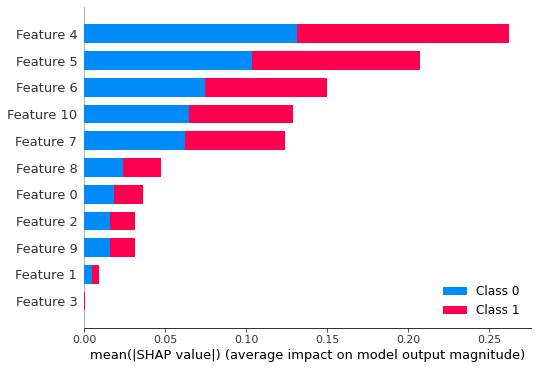

In [69]:
shap.summary_plot(shap_values, prepare(X_test), plot_type="bar")

## Save

In [124]:
with open("./models/model.pk", "wb") as f : 
    pk = pickle.dumps(grid)
    f.write(pk)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Embarked',
                                                                          'Sex'])])),
                                       ('imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('estimator',
                                        RandomForestClassifier())]),
             n_jobs=-1, param_grid={}, return_train_score=True)